#### <strong><font color=cornflowerblue>第三次作品：三個分類器於AT&T影像資料集的評比實驗</font></strong>
學號：711331135

姓名：王宣懿

<hr>

#### <strong>作品目標</strong>：

本作品透過實作與比較三種常見分類模型——邏輯斯回歸（Logistic Regression）、支援向量機（SVM）與多層感知器（MLP, Multilayer Perceptron）——分析其在處理高維度影像資料時的分類表現差異。研究同時應用主成分分析（PCA）進行資料降維，並結合 GridSearchCV 方法系統性調整與比較模型超參數設定，全面評估不同模型與參數組合在原始與降維資料下的分類效能。透過模型準確率及多項評估指標（如 recall、precision、f1-score），深入探討降維對於資料結構簡化與模型效能提升的影響。


<hr>

#### <strong>載入套件</strong>：

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import  GridSearchCV, \
                        StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_montage(X, n, m, h, w):
    '''
    X: image matrix in which each column represents an image
    n, m: image size n x m
    h, w : create an h x w montage image with figsize = (w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w, h))
    if X.shape[1] < w * h: # 影像張數不到 w x h 張，用 0 向量補齊     
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(n, m), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()



<hr>
<hr>

#### **<font color=cornflowerblue>第 1 題：</font>**  
以AT&T資料為例，分別從原始資料集與PCA處理後資料集進行羅吉斯回歸分類練習。

**資料來源:** [AT&T Dataset](https://github.com/ntpuccw/InClassCoding/blob/ab4b5c67fd15885b7a573f2932a40958d14ed0cf/ATT_faces.ipynb)

**公式說明:** 

- 將一組多變量資料x的線性組合依機率大小，分配到K個類別中最大的類別。由兩個候驗機率的比值取對數後，稱為對數勝算比或邏輯轉換，以此對數勝算比做為線性回歸的應變數。
$$
\log \frac{Pr(G = K - 1 \mid X = \mathbf{x})}{Pr(G = K \mid X = \mathbf{x})} 
= \beta_{(K - 1)0} + \boldsymbol{\beta}_{K - 1}^T \mathbf{x}
$$

- 此外，也可寫成:
$$
Pr(G = k \mid X = \mathbf{x}) = 
\frac{e^{\beta_{k0} + \boldsymbol{\beta}_k^T \mathbf{x}}}
{1 + \sum_{l=1}^{K-1} e^{\beta_{l0} + \boldsymbol{\beta}_l^T \mathbf{x}}},
\quad k = 1, 2, \dots, K - 1
$$



#### (1) 匯入資料，觀察資料的基本屬性。

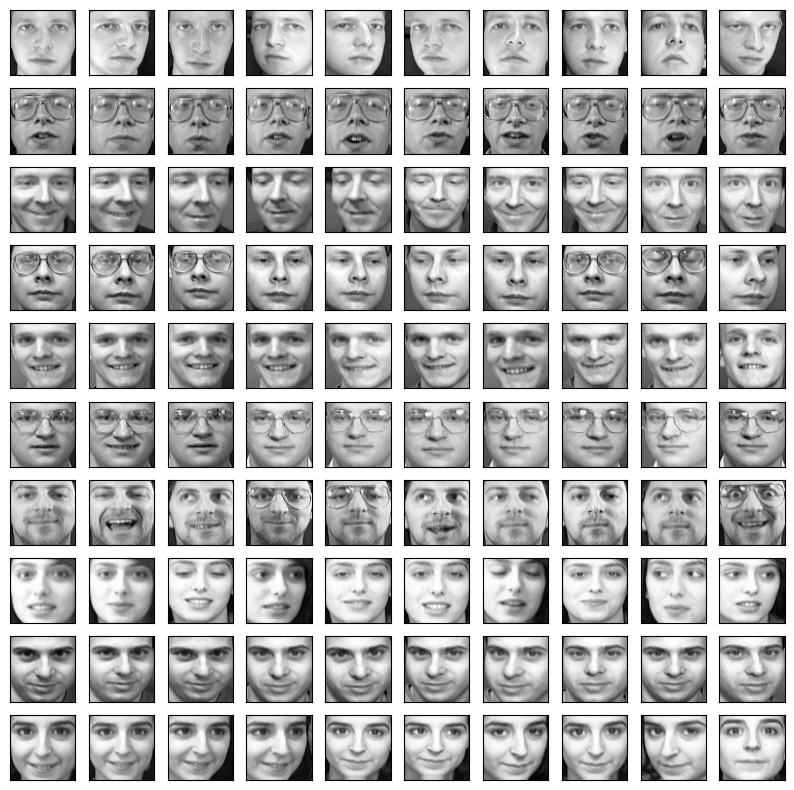

【X 的 Shape】: (400, 4096)
【y 的 Shape】: (400,)
【labels 的 Unique 值】: 40


In [5]:

df = pd.read_csv("C:/Users/user/Downloads/face_data.csv")
n_persons = df['target'].nunique() 
#print(df.columns)
#print(len(df))
X = np.array(df.drop('target', axis=1)) # 400 x 4096
y = np.array(df['target'])
n, m = 64, 64
show_montage(X.T, n, m, 10, 10)
print('【X 的 Shape】:', X.shape)
print('【y 的 Shape】:', y.shape)
print('【labels 的 Unique 值】:', n_persons)

##### (2) 將資料以 7:3 的比例分為訓練集與測試集，並對自變數（X）進行標準化處理，以消除不同特徵間的量綱差異。



In [4]:

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30)
scaler=StandardScaler()
x_train_=scaler.fit_transform(x_train)
x_test_=scaler.fit_transform(x_test)


##### (3) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 LogisticRegression 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.linear_model import LogisticRegressionCV`

`from sklearn.metrics import accuracy_score,classification_report`


##### 2) 原始資料進行模型訓練，透過 Grid Search 方法調整分類器類型與正則化參數 C 值，尋找最佳模型組合。

In [7]:
opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg'],#, 'sag','saga'], \
              'C':[0.1, 1, 10]} # parameters for GridSearchCV
# parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg',\
#                         'sag','saga']}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
grid = GridSearchCV(estimator=LogisticRegression(**opts), \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy") 
grid.fit(x_train_, y_train)
# grid.fit(X, y)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'C': 10, 'solver': 'lbfgs'}
0.9690476190476192
LogisticRegression(C=10, max_iter=1000000, tol=1e-06)


##### 3) 原始資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對分類器類型 ( lbfgs, liblinear , newton-cg )、正則化參數 C 值 ( 0.1, 1, 10 ) ，找到最佳模型組合分類器為lbfgs ， 正則化參數為 0.1 。 

In [33]:


opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'lbfgs'  # 'lbfgs' is the default
Cs = [10] # 20 values of C from 1e-5 to 1e5
cv = 5 # 5-fold cross-validation
# --- Logistic Regression with Cross Validation ---
clf_originalCV = LogisticRegressionCV(solver = solver, Cs = Cs, cv = cv, **opts) 
clf_originalCV.fit(x_train_, y_train) # input data must be (n_samples x n_features)
y_pred = clf_originalCV.predict(x_test_)

# --- Results Report ---
# print training score
print(f"Training score = {accuracy_score(y_train, clf_originalCV.predict(x_train_)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_originalCV.score(x_test_, y_test):.2%}\n")
print(classification_report(y_test, y_pred,zero_division=0))

c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Training score = 100.00%

Testing score = 96.67%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      0.83      0.91         6
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         5
          16       1.00      1.

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 訓練集準確率達 100%，理論上這可能暗示模型過擬合，但由於測試集準確率仍維持在 96.67%，推測目前模型尚未真正過擬合（可能資料乾淨或特徵很好）。
- 少數類別（如 class 5, 22, 39）出現 precision = 0.67、recall = 1.00 的情形，代表模型傾向於「猜中即可」，偶爾會將其他類別誤分類為這些類別。

##### 4) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之五之特徵數作為候選範圍。隨後，透過 Grid Search 方法，同時調整分類器類型 、 正則化參數 C 值與主成分數，尋找最佳模型組合。

In [9]:

##pca components 

pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.005)
qualified_components = np.where(condition)[0] + 1  
print("符合條件的 component 編號：", qualified_components)

#pipline

opts = dict(tol = 1e-6, max_iter = int(1e6)) # parameters for LogisticRegression
parameters = {
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'logreg__C': [0.1, 1, 10],
    'pca__n_components': qualified_components.tolist()
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('logreg', LogisticRegression(**opts))
])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy"
                ) 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

符合條件的 component 編號： [26 27]
{'logreg__C': 0.1, 'logreg__solver': 'newton-cg', 'pca__n_components': 27}
0.9547619047619049
Pipeline(steps=[('pca', PCA(n_components=27)),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=1000000, solver='newton-cg',
                                    tol=1e-06))])


##### 5) 特徵資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對分類器類型 ( lbfgs, liblinear , newton-cg )、正則化參數 C 值 ( 0.1, 1, 10 ) 與主成分數(25、26)，找到最佳模型組合分類器為lbfgs ， 正則化參數為 0.1 ， 主成分數為26 。 


In [13]:


opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=0)
solver = 'newton-cg' 
Cs = [0.1] # 20 values of C from 1e-5 to 1e5
cv = 5 # 5-fold cross-validation
# --- PCA ---
pca=PCA(n_components=27)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

# --- Logistic Regression with Cross Validation ---
clf_originalCV = LogisticRegressionCV(solver = solver, Cs = Cs, cv = cv, **opts) 
clf_originalCV.fit(x_train_pca, y_train) # input data must be (n_samples x n_features)
y_pred = clf_originalCV.predict(x_test_pca)

# --- Results Report ---

print(f"Training score = {accuracy_score(y_train, clf_originalCV.predict(x_train_pca)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_originalCV.score(x_test_pca, y_test):.2%}\n")
print(classification_report(y_test, y_pred,zero_division=0))



c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Training score = 100.00%

Testing score = 91.67%

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      0.50      0.67         2
           4       1.00      0.83      0.91         6
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.50      1.00      0.67         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       0.83      1.00      0.91         5
          16       1.00      1.

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 套入最佳參數做交叉驗證準確率達 95.48%，使用相同參數於 LogisticRegressionCV 在測試集上實測為 91.67%，顯示泛化能力仍相當穩定。
- 少數樣本數較低的類別（如類別 28、3、12、39）略顯不穩定（recall 高、precision 偏低）。


##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 C |
|--------------|--------|--------|
| Original LR  | lbfgs  | 0.1    | 
| PCA LR       | lbfgs  | 0.1    | 

- 在邏輯斯迴歸中，C 值越小代表正則化越強（模型越保守），可以防止過擬合。

- PCA 沒有改變特徵的性質，僅簡化了空間，但最佳 solver 並未因而改變

<hr>
<hr>

#### **<font color=cornflowerblue>第 2 題：</font>**  
以AT&T資料為例，分別從原始資料集與PCA處理後資料集進行支援向量機分類練習。

**資料來源:** [AT&T Dataset](https://github.com/ntpuccw/InClassCoding/blob/ab4b5c67fd15885b7a573f2932a40958d14ed0cf/ATT_faces.ipynb)

**公式說明:** 

- 支援向量機的原理是在二維平面上建立一條直線，或在高維空間建立一個超平面，
$$
\mathbf{w}^T \mathbf{x} + \mathbf{b} = 0
$$ 

- 其中 x 代表變數向量
$$
\begin{bmatrix} x_1 & x_2 & \cdots & x_p \end{bmatrix}^T
$$
- 使得超平面能將兩個群組分開。

- 當面對超平面（線性）無法分開的群組資料時，可以將資料投射到更高維的空間，使得該資料在高維度空間為線性可分。這個觀念引入了非線性的核函數（kernels），改寫為一般式，
$$
\mathbf{w}^T \phi(\mathbf{x}) + \mathbf{b} = 0
$$



##### (1) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 SVM 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.svm import SVC`

`from sklearn.metrics import accuracy_score,classification_report`

**注意事項：**
1. 為了保持實驗的一致性，本次實驗將使用與第一題相同的訓練集與測試集資料，並將其應用於所選的模型進行訓練與預測。

##### 1) 原始資料進行模型訓練，透過 Grid Search 方法調整核函數類型（kernel）與正則化參數 C 值，尋找最佳模型組合。

In [29]:

opts = dict(probability=True, random_state=0) # parameters for LogisticRegression
parameters = {
    'svc__kernel': ["linear","rbf","poly","sigmoid"],
    'svc__C': [0.1, 1, 10],
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('svc', SVC(**opts))])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy"
                ) 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'svc__C': 0.1, 'svc__kernel': 'linear'}
0.9523809523809523
Pipeline(steps=[('svc',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=0))])


##### 2) 原始資料使用最佳參數建立一個新的 LogisticRegression 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對核函數類型 ( linear , rbf , poly , sigmoid )、正則化參數 C 值 ( 0.1, 1, 10 ) ，找到最佳模型組合分類器為linear ， 正則化參數為 0.1 。 

In [30]:


C = 0.1 # SVM regularization parameter
opts = dict(probability=True, random_state=0) # default decision function shape is 'ovr'
# opts = dict(C = C, decision_function_shape = ’ovo’, \
# tol = 1e−6, max_iter = int(1e6))
clf_svm = SVC(kernel='linear', **opts)

clf_svm.fit(x_train_, y_train)
print(f"Training score = {accuracy_score(y_train, clf_svm.predict(x_train_)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {clf_svm.score(x_test_, y_test):.2%}\n")
predictions = clf_svm.predict(x_test_)
print(classification_report(y_test, predictions))

Training score = 100.00%

Testing score = 90.83%

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      0.83      0.91         6
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.60      1.00      0.75         3
          13       1.00      1.00      1.00         1
          14       0.75      1.00      0.86         3
          15       1.00      0.80      0.89         5
          16       1.00      1.

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 訓練集準確率為 100%，但測試集仍有 90.83% 的高準確率，顯示過擬合影響有限，且模型在泛化上仍有不錯表現。
- class 28：recall = 0.29，f1-score = 0.44，可能表示模型難以辨識這類樣本。
- 類似 class 20, 39 的 precision 偏低，說明模型容易將其他類別誤分類為這些。

##### 3) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之五之特徵數作為候選範圍。隨後，透過 Grid Search 方法，同時調整核函數類型 、 正則化參數 C 值與主成分數，尋找最佳模型組合。

In [31]:

##pca components explained ratio

pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.005)
qualified_components = np.where(condition)[0] + 1  
print("符合條件的 component 編號：", qualified_components)

#pipline

opts = dict(probability=True, random_state=0) # parameters for LogisticRegression
parameters = {
    'svc__kernel': ["linear","rbf","poly","sigmoid"],
    'svc__C': [0.1, 1, 10],
    'pca__n_components': qualified_components.tolist()
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('svc', SVC(**opts))
])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=parameters, cv=cv, 
                scoring=['accuracy','f1_macro'], refit="accuracy"
                ) 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

符合條件的 component 編號： [26 27]
{'pca__n_components': 27, 'svc__C': 1, 'svc__kernel': 'linear'}
0.9476190476190478
Pipeline(steps=[('pca', PCA(n_components=27)),
                ('svc',
                 SVC(C=1, kernel='linear', probability=True, random_state=0))])


##### 4) 特徵資料使用最佳參數建立一個新的 SVM 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 核函數類型 ( linear , rbf , poly , sigmoid )、正則化參數 C 值 ( 0.1, 1, 10 )、與主成分數(25、26) ，找到最佳模型組合分類器為linear ， 正則化參數為 1 ，主成分數為25 。 

In [32]:

opts = dict(probability=True, random_state=0)
kernel = 'linear' 
C = 0.1 # 20 values of C from 1e-5 to 1e5

# --- PCA ---
pca=PCA(n_components=27)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

# --- Logistic Regression with Cross Validation ---
SVC_originalCV = SVC(kernel = kernel, C=C, **opts) 
SVC_originalCV.fit(x_train_pca, y_train) # input data must be (n_samples x n_features)
y_pred = SVC_originalCV.predict(x_test_pca)

# --- Results Report ---

print(f"Training score = {accuracy_score(y_train, SVC_originalCV.predict(x_train_pca)):.2%}\n")
# print testing score
# print(f"Testing score = {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Testing score = {SVC_originalCV.score(x_test_pca, y_test):.2%}\n")
print(classification_report(y_test, y_pred))


Training score = 100.00%

Testing score = 91.67%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       0.33      1.00      0.50         1
           3       1.00      1.00      1.00         2
           4       1.00      0.83      0.91         6
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.75      1.00      0.86         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      0.80      0.89         5
          16       1.00      1.

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 使用 PCA 降維（27主成分）搭配線性核的 SVC 模型，在 5-fold 交叉驗證中達到 95.24% 的最佳準確率，實測測試集也保有穩定的 91.67% 準確率與 F1 表現 0.92，顯示此模型在高維多分類問題中具備高度的準確性與穩定性。
- class 2：precision = 0.33, recall = 1.00 → 模型容易誤判其他類為 class 2。
- class 28：precision = 1.00, recall = 0.29 → 模型無法有效找出大部分的 class 28 樣本，僅抓到少數。
- class 20：precision = 0.25, recall = 1.00 → 同樣有過度誤判現象。

##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 C |
|--------------|--------|--------|
| Original SVM  | linear  | 0.1    | 
| PCA SVM       | linear  | 1    | 

- PCA 雖壓縮了維度，但仍保留足夠線性結構，模型無需依賴 RBF 或其他非線性核函數。

- 在原始資料中，特徵維度及雜訊多好使用 C=0.1（較強正則化），讓模型更穩健，不強求過度擬合訓練資料。在 PCA 降維資料中，維度壓縮後雜訊減少、特徵更加濃縮與可區分，SVM 可以用較大的 C 值（如 1）來更加緊貼訓練資料，從而提昇分類表現。

<hr>
<hr>

#### **<font color=cornflowerblue>第 3 題：</font>**  
以AT&T資料為例，分別從原始資料集與PCA處理後資料集進行神經網路分類練習。

**資料來源:** [AT&T Dataset](https://github.com/ntpuccw/InClassCoding/blob/ab4b5c67fd15885b7a573f2932a40958d14ed0cf/ATT_faces.ipynb)

**公式說明:** 

- 一個典型的前饋式神經網路模型，包含一層隱藏層（Hidden Layer）。在這個模型中，輸入層（Input）包含 p 個變數，隱藏層則有 q 個神經元，輸出層（Output Layer）包含 r 個輸出變數（圖中 r = 3）。輸入變數的數量 p 和輸出變數的數量 r 會依據具體問題的需求而有所不同。例如，若用於人臉辨識，則 p 代表影像的大小（或特徵向量的維度），而 r 代表辨識的類別數。

- 假設輸入端的 p 個變數表示為 $$ x_1, x_2, \dots, x_p $$

- 輸出端的 r 個變數表示為 $$ \hat{y}_1, \hat{y}_2, \dots, \hat{y}_r $$

- 則前饋式類神經網路的輸出與輸入間的數學關係寫成
$$
\hat{y}_k = \sum_{i=1}^{q} w_{ki}^2 \left( \sum_{j=1}^{p} w_{ij}^1 x_j + b_i^1 \right) + b_k^2, \quad 1 \leq k \leq r
$$

-其中函數 g(·) 稱為激發函數（activation function），可以選擇為（−1 ≤ g(z) ≤ 1）
$$
g(z) = c_1 \frac{1 - e^{-c_2 z}}{1 + e^{-c_2 z}}
$$


##### (1) 本研究分別以經 PCA 抽取之特徵資料與原始資料作為兩組輸入變數，採用 Multilayer Perceptron 模型並透過 Grid Search 調整最適超參數進行訓練。針對每組資料集皆使用相同的訓練集進行擬合，並於測試集上進行預測，透過準確率（accuracy）作為指標，評估模型在不同資料表示方式下的分類效能。

套件：

`from sklearn.model_selection import train_test_split`

`from sklearn.decomposition import PCA`

`from sklearn.model_selection import  GridSearchCV`

`from sklearn.neural_network import MLPClassifier`

`from sklearn.metrics import accuracy_score,classification_report`

**注意事項：**
1. 為了保持實驗的一致性，本次實驗將使用與第一題相同的訓練集與測試集資料，並將其應用於所選的模型進行訓練與預測。

##### 1) 原始資料進行模型訓練，透過 Grid Search 方法調整隱藏層的結構（hidden layer size）與正則化參數 （ alpha ） ，尋找最佳模型組合。

In [29]:

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001]  # L2正則化強度
}

grid = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(x_train_, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy: {:.2f}%".format(100 * grid.best_score_))

c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'solver': 'adam'}
Best CV accuracy: 95.71%


##### 2) 原始資料使用最佳參數建立一個新的 Multilayer Perceptron 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對隱藏層的結構 ( (64, ) , (128, ) , (128, 64) )、激勵函數 ( relu , logistic )、正則化參數 alpha 值 ( 0.0001, 0.001 ) ，找到最佳模型組合隱藏層的結構(128,)，激勵函數為 logistic ， 正則化參數為 0.001 。 

accuracy for test data: 95.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         4
          16       1.00      0.43      0.60       

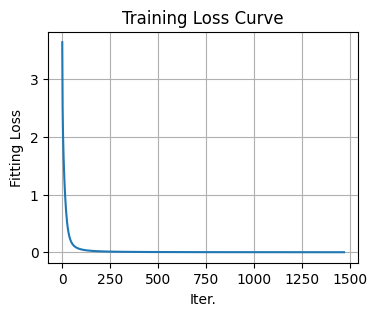

In [ ]:


# hidden_layers = (512,) # one hidden layer
# activation = 'relu' # the default
hidden_layers = (128,) # one hidden layer
activation = 'logistic' # the default= 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
# solver = 'sgd' # not efficient, need more tuning
# solver = 'lbfgs' # not suitable here
solver = 'adam' # default solver
alpha= 0.001
clf_MLP = MLPClassifier(solver = solver, **opts,alpha=alpha) 
clf_MLP.fit(x_train_, y_train) # X_train = (samples, features), y_train = (samples,)
predictions = clf_MLP.predict(x_test_) #output a class label for each sample
# print("accuracy for tested data: {:.2f}%".format(100*np.mean(y_test_hat == y_test)))
print("accuracy for test data: {:.2f}%".format(100*clf_MLP.score(x_test_, y_test)))
print(classification_report(y_test, predictions,zero_division=0))

fig, ax = plt.subplots(1, 1, figsize=(4,3))
plt.plot(clf_MLP.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

plt.show() 

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 測試準確率為 95%，這是相當高的表現，顯示出模型具有較強的泛化能力，能夠在未見過的測試數據上保持高準確性。
- 由於部分類別（如類別 16 和 18）的召回率較低，這可能暗示訓練數據中存在某些類別的不平衡問題。儘管整體測試準確率高，但這些不平衡的類別可能會導致模型性能的下降。

##### 3) 特徵資料符合主成分總解釋變異量達 80% 以上，且邊際貢獻仍高於千分之五之特徵數作為候選範圍。隨後，透過 Grid Search 方法 ， 同時調整隱藏層的結構 、 正則化參數 alpha 值 、 激勵函數與主成分數 ， 尋找最佳模型組合 。

In [49]:

##pca components explained ratio

pca=PCA().fit(x_train_)
cumulative=np.cumsum(pca.explained_variance_ratio_)
marginal_gain = np.diff(cumulative, prepend=0)
condition = (cumulative >= 0.8) & (marginal_gain >= 0.005)
qualified_components = np.where(condition)[0] + 1  
print("符合條件的 component 編號：", qualified_components)

#pipline


param_grid = {
    'mlp__hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'mlp__activation': ['relu', 'logistic'],
    'mlp__solver': ['adam'],
    'mlp__alpha': [0.0001, 0.001],
    'pca__n_components': qualified_components.tolist()    # L2正則化強度
}
# parameters for GridSearchCV
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, \
                            random_state=0) # 5-fold CV
 
pipeline = Pipeline([
    ('pca', PCA()),
    ('mlp', MLPClassifier(max_iter=1000))
])
grid = GridSearchCV(estimator=pipeline, \
                param_grid=param_grid, cv=5, 
                scoring=['accuracy','f1_macro'], refit="accuracy") 
grid.fit(x_train_, y_train)
cv_logistic = pd.DataFrame(data = grid.cv_results_)
# print the results
# print(cv_logistic.head())
# cv_logistic.to_csv(results_file) # 打開來觀察結果
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)





符合條件的 component 編號： [25 26]


c:\Python310\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


{'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128,), 'mlp__solver': 'adam', 'pca__n_components': 26}
0.9357142857142857
Pipeline(steps=[('pca', PCA(n_components=26)),
                ('mlp',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(128,),
                               max_iter=1000))])


##### 4) 特徵資料使用最佳參數建立一個新的 Multilayer Perceptron 模型，使用訓練資料擬合、測試資料預測，最後印出訓練與測試的準確率（accuracy score）。

**注意事項：**
1. 針對隱藏層的結構 ( (64, ) , (128, ) , (128, 64) )、激勵函數 ( relu , logistic )、正則化參數 alpha 值 ( 0.0001, 0.001 )，主成分數 ( 25、26 ) ，找到最佳模型組合隱藏層的結構(128,)，激勵函數為 logistic ， 正則化參數為 0.001 ，主成分數26 。

accuracy for test data: 93.33%
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4
           5       0.67      1.00      0.80         2
           6       0.67      1.00      0.80         2
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         1
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         4
          16       1.00      0.71      0.83       

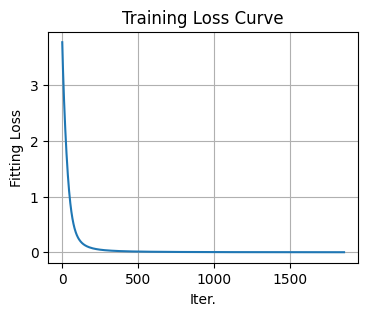

In [ ]:
# --- PCA ---
pca=PCA(n_components=26)
x_train_pca=pca.fit_transform(x_train_)
x_test_pca = pca.transform(x_test_)

#-----multilayer perceptron------

hidden_layers = (128,) # one hidden layer
activation = 'logistic' # the default= 'relu'
opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'adam' # default solver
alpha= 0.001
clf_MLP = MLPClassifier(solver = solver, **opts,alpha=alpha) 
clf_MLP.fit(x_train_pca, y_train) # X_train = (samples, features), y_train = (samples,)
predictions = clf_MLP.predict(x_test_pca) #output a class label for each sample
# print("accuracy for tested data: {:.2f}%".format(100*np.mean(y_test_hat == y_test)))
print("accuracy for test data: {:.2f}%".format(100*clf_MLP.score(x_test_pca, y_test)))
print(classification_report(y_test, predictions,zero_division=0))

fig, ax = plt.subplots(1, 1, figsize=(4,3))
plt.plot(clf_MLP.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()



##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 在訓練集上的表現接近 100%， 測試集的準確率達到 93.33%，顯示該 Multilayer Perceptron (MLP) 模型在預測過程中表現良好，表示模型並未過度擬合。
- 類別 16 和類別 31 的 precision 和 recall 分數較低，這可能是因為這些類別的樣本數量較少，或者該類別的特徵與其他類別相似，導致分類困難。

##### **<font color=lightseagreen> PCA前後分類器與參數比較：</font>**  
| Model        | 分類器 | 參數 alpha |
|--------------|--------|--------|
| Original MLP  | logistic  | 0.001    | 
| PCA MLP       | logistic | 0.001    | 

- 模型學習能力仍受 activation 決定，PCA 未改變非線性本質。

- alpha 不變，此表示 PCA 並未顯著降低 overfitting 的風險。

<hr>
<hr>

#### **<font color=cornflowerblue>PCA 降維前後分類器準確率比較：</font>** 

| Model      | Accuracy | Macro avg Precision | Macro avg Recall | Macro avg F1-score | Weighted avg Precision | Weighted avg Recall | Weighted avg F1-score |
|------------------------|----------|---------------------|------------------|--------------------|------------------------|---------------------|-----------------------|
| Original LR | 0.97     | 0.97                | 0.98             | 0.97               | 0.98                   | 0.97                | 0.97                  |
| PCA LR     | 0.92     | 0.93                | 0.94             | 0.92               | 0.95                   | 0.92                | 0.92                  |
| Original SVM | 0.91     | 0.92                | 0.94             | 0.91               | 0.95                   | 0.91                | 0.91                  |
| PCA SVM     | 0.92     | 0.93                | 0.95             | 0.92               | 0.96                   | 0.92                | 0.92                  |
| Original MP | 0.95     | 0.93                | 0.92             | 0.92               | 0.98                   | 0.95                | 0.96                  |
| PCA MP     | 0.93     | 0.89                | 0.90             | 0.88               | 0.97                   | 0.93                | 0.94                  |

##### **<font color=lightseagreen>注意事項與討論：</font>**  

##### 1 ) Logistic Regression
- 原始 LR 表現全面最佳，三項指標都達到最高值（0.97），顯示原始特徵資訊對於 Logistic Regression 的線性決策效果極佳。
- PCA LR 在所有指標皆下降約 5%，表示 PCA 雖保留 80% 的變異，但對於線性分類來說，壓縮後的主成分可能移除了可分性的關鍵特徵。

結論：Logistic Regression 在原始特徵空間下分類效果最佳，不建議加入 PCA。若無運算效率需求，保留原始特徵是最理想的選擇。

##### 2 ) SVM
- 原始 SVM 表現略遜於 Logistic Regression，可能因高維特徵中存在雜訊或非支持向量資料分布造成分類邊界不夠清晰。
- PCA SVM 各項指標皆小幅提升（+0.01），代表 PCA 有助於去除雜訊特徵，進一步強化支持向量機的分類能力。

結論：SVM 搭配 PCA 可有效提升整體效能，建議與 PCA 一起使用，尤其在高維或特徵冗餘資料中更為合適。

##### 3 ) Multilayer Perceptron
- 原始 MP 表現接近 LR，整體準確率達 0.95，且 Weighted F1 為 0.96，顯示其在處理樣本比例不均（大類別）表現優異。
- 加入 PCA 後所有指標下降，尤其 Macro F1 大幅下降至 0.88，代表 MLP 在被限制主成分後無法完整擷取資料中的非線性特徵與邊界。此外，MP 依賴多層神經元結構進行深層特徵學習，過度壓縮特徵空間會大幅損害其表現。

結論：MP 不適合與 PCA 搭配，尤其是資料特徵具高度非線性時。若使用 MP 模型，應保留完整特徵空間並搭配 class weight 或資料平衡處理。
